In [2]:
import numpy as np
import pandas as pd
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, LSTM, Dropout, Embedding, CuDNNGRU
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
#Lemmatizer => Zeyrek
import zeyrek
analyzer = zeyrek.MorphAnalyzer()

In [4]:
#Misspelled Words => Zemberek
#!pip install jpype1
from jpype import JClass,JString,getDefaultJVMPath,shutdownJVM,startJVM,isJVMStarted

ZEMBEREK_PATH = 'zemberek-full.jar'

#Or you can not re-run the cell if it has error
def init_jvm():
    if isJVMStarted():
        return "JVM is already started"
    startJVM(getDefaultJVMPath(),
        '-ea',
        f'-Djava.class.path={ZEMBEREK_PATH}',
        convertStrings=False)

init_jvm()

TurkishMorphology:JClass=JClass('zemberek.morphology.TurkishMorphology')
TurkishSpellChecker:JClass=JClass('zemberek.normalization.TurkishSpellChecker')

morphology: TurkishMorphology = TurkishMorphology.createWithDefaults()
spell_checker: TurkishSpellChecker = TurkishSpellChecker(morphology)  

# Verileri Yükleme

In [4]:
dataset = pd.read_csv('categorical.csv')

In [5]:
#Shuffle
dataset = dataset.sample(frac=1).reset_index(drop=True)

In [6]:
dataset

,Comment,Rating
0,Çöp gibi bi maske telli diyo acıklamada ama te...,0
1,Tavsiye etmiyorum oyuncak gibi duruyor,0
2,ürün geldi ama uzun süre sonra geldi 2 3 hft o...,0
3,Herkes çok övdü bu ürünü ama ne pek memnun kal...,1
4,Ürün dar kalıp mankendeki gibi olmadı 170/60 ...,1
...,...,...
138860,piyasadaki maskelerden gayet iyi.,2
138861,Abartıldığı kadar değil üzgünüm. Hindistan cev...,1
138862,memnun kaldım güzel,2
138863,"Arkadaşlar almayın, yere düşünce paramparça ol...",0


In [7]:
dataset['Rating'].value_counts()

1    47749
0    45666
2    45450
Name: Rating, dtype: int64

## Etiketleri ve yorumları birbirinden ayırıyoruz.

In [10]:
#Etiketler
target = dataset['Rating'].values.tolist()

#Yorumlar
data = dataset['Comment'].values.tolist()

## train_test_split | 80% train, 20% test

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size = 0.2, random_state = 42)

# Tokenization

In [16]:
#Stop words
def make_data_without_stop_words(data, stop_words):
    for i, sentence in enumerate(data):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        data[i] = ' '.join(new_sent)
    return data

stop_words = set(stopwords.words("turkish"))
data = make_data_without_stop_words(data, stop_words)

In [31]:
#stop words + lemmatizing
def stop_lemmatizing(data, stop_words):
    for i, sentence in enumerate(data):
        try:
            new_sent = [analyzer.analyze(word)[0][0][1] for word in sentence.split() if word not in stop_words]
        except IndexError:
            new_sent = None
        
        if new_sent is not None:
            data[i] = ' '.join(new_sent)
    return data

stop_words = set(stopwords.words("turkish"))
data = stop_lemmatizing(data, stop_words)

In [16]:
#stop words + misspelled
def stop_misspelled(data, stop_words):
    for i, sentence in enumerate(data):
        new_sent_list = [word for word in sentence.split() if word not in stop_words]
        for j, word in enumerate(new_sent_list):
            if word not in stop_words:
                if spell_checker.suggestForWord(JString(word)):
                    if not spell_checker.check(JString(word)):
                        spellCheckedWord = str(spell_checker.suggestForWord(JString(word))[0])
                        new_sent_list[j] = spellCheckedWord
                        data[i] = ' '.join(new_sent_list[j])
        
    return data

stop_words = set(stopwords.words("turkish"))
data = stop_misspelled(data, stop_words)

In [18]:
#stop words + misspelled + lemmatizing
def stop_lemma_misspelled(data, stop_words):
    for i, sentence in enumerate(data):
        
        #misspelled(ZEMBEREK) + stop_words(NLTK)
        new_sent_list = [word for word in sentence.split() if word not in stop_words]
        for j, word in enumerate(new_sent_list):
            if word not in stop_words:
                if spell_checker.suggestForWord(JString(word)):
                    if not spell_checker.check(JString(word)):
                        spellCheckedWord = str(spell_checker.suggestForWord(JString(word))[0])
                        new_sent_list[j] = spellCheckedWord
                        
        
        #Lemmatizing(ZEYREK)
        try:
            new_sent_list = [analyzer.lemmatize(word)[0][1][0] for word in new_sent_list]
        except IndexError:
            new_sent_list = None
        
        if new_sent_list is not None:
            data[i] = ' '.join(new_sent_list)
    return data

stop_words = set(stopwords.words("turkish"))
data = stop_lemma_misspelled(data, stop_words)

shutdownJVM()

In [17]:
num_words = 10000

tokenizer = Tokenizer(num_words = num_words)

In [18]:
tokenizer.fit_on_texts(data)

In [19]:
tokenizer.word_index

{'bir': 1,
 'ürün': 2,
 'güzel': 3,
 'iyi': 4,
 'değil': 5,
 'geldi': 6,
 'aldım': 7,
 'çok': 8,
 'bi': 9,
 'tavsiye': 10,
 'kadar': 11,
 'oldu': 12,
 'yok': 13,
 'cok': 14,
 '1': 15,
 'beden': 16,
 'gayet': 17,
 'ürünü': 18,
 'kaliteli': 19,
 'iade': 20,
 'biraz': 21,
 'var': 22,
 'sonra': 23,
 'kötü': 24,
 'uzun': 25,
 'ben': 26,
 'fakat': 27,
 '2': 28,
 'kesinlikle': 29,
 'ederim': 30,
 'tam': 31,
 'göre': 32,
 'kullanıyorum': 33,
 'küçük': 34,
 'maske': 35,
 'bile': 36,
 'memnun': 37,
 'olarak': 38,
 'büyük': 39,
 'almayın': 40,
 'ince': 41,
 'uygun': 42,
 'ses': 43,
 'kumaşı': 44,
 'gün': 45,
 'kalitesi': 46,
 'kargo': 47,
 'gerçekten': 48,
 '3': 49,
 'alın': 50,
 'kokusu': 51,
 'hediye': 52,
 'harika': 53,
 'fazla': 54,
 'bence': 55,
 'almıştım': 56,
 'aşırı': 57,
 'beğenmedim': 58,
 'ilk': 59,
 'beğendim': 60,
 'hemen': 61,
 'asla': 62,
 'tek': 63,
 'ürünün': 64,
 'sadece': 65,
 'kalitesiz': 66,
 'işe': 67,
 'ettim': 68,
 'hızlı': 69,
 'fiyatına': 70,
 'teşekkürler': 71,
 'ancak

In [20]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [23]:
x_test_tokens = tokenizer.texts_to_sequences(x_test)

# Padding

In [24]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]

num_tokens = np.array(num_tokens)

In [25]:
np.mean(num_tokens)

12.088683253519605

In [26]:
np.max(num_tokens)

73

In [27]:
np.argmax(num_tokens)

100153

In [28]:
x_train[1794]

'Kullandığım bir üründü. Gayet kaliteli uzun kullanıma uygun. Kulakları acıtmıyor.'

In [29]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

32

In [30]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9448457134627156

In [31]:
x_train_pad = pad_sequences(x_train_tokens, maxlen = max_tokens)

In [32]:
x_test_pad = pad_sequences(x_test_tokens, maxlen = max_tokens)

In [33]:
x_train_pad.shape

(111092, 32)

In [34]:
x_test_pad.shape

(27773, 32)

In [35]:
np.array(x_train_tokens[800])

array([  18, 1149,   46,   44,   24])

In [36]:
x_train_pad[800]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,   18, 1149,   46,   44,   24])

## Token to string function

In [37]:
idx = tokenizer.word_index

inverse_map = dict(zip(idx.values(), idx.keys()))

In [38]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    
    text = ' '.join(words)
    
    return text

#### Fonksiyon çalışırlık testi

In [39]:
x_train[800]

'ürünü beğenemedim kalitesi kumaşı kötü'

In [40]:
tokens_to_string(x_train_tokens[800])

'ürünü beğenemedim kalitesi kumaşı kötü'

# Embedding ve Sinir Ağı Oluşturma

In [41]:
model = Sequential()

# Word2Vec

In [42]:
embedding_size = 400

from gensim.models import KeyedVectors
tr_word2vec_model_path = 'trmodel'
word2vec = KeyedVectors.load_word2vec_format(tr_word2vec_model_path, binary=True)

embedding_matrix = np.random.uniform(-1, 1, (num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    
    if i < num_words:
        
        if word in word2vec:
            embedding_vector = word2vec[word]
            embedding_matrix[i] = embedding_vector


In [43]:
embedding_matrix.shape

(10000, 400)

# GloVe

In [42]:
embedding_size = 300

from gensim.models import KeyedVectors
word2vec_output = 'glove_model'
glove = KeyedVectors.load_word2vec_format(word2vec_output, binary=False)

embedding_matrix = np.random.uniform(-1, 1, (num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    
    if i < num_words:        
        if word in glove:
            embedding_vector = glove[word]
            embedding_matrix[i] = embedding_vector

In [43]:
embedding_matrix.shape

(10000, 300)

In [42]:
embedding_size = 50

In [44]:
model.add(Embedding(input_dim = num_words,
                    output_dim = embedding_size,
                    weights=[embedding_matrix],
                    input_length = max_tokens,
                    name = 'embedding_layer'))

In [45]:
model.add(LSTM(units=16, return_sequences=True))
model.add(LSTM(units=8, return_sequences=True))
model.add(LSTM(units=4))
model.add(Dense(3, activation='sigmoid'))

In [46]:
optimizer = Adam(lr=1e-3)

# Modeli Derleme

In [47]:
import keras_metrics

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', 'mae', 'mse', keras_metrics.precision(), keras_metrics.recall(),keras_metrics.f1_score()])

Using TensorFlow backend.


tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 32, 400)           4000000   
_________________________________________________________________
lstm (LSTM)                  (None, 32, 16)            26688     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 8)             800       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense (Dense)                (None, 3)                 15        
Total params: 4,027,711
Trainable params: 4,027,711
Non-trainable params: 0
_________________________________________________________________


# Model Eğitimi

In [49]:
from keras.utils import to_categorical

history = model.fit(x_train_pad, to_categorical(y_train), epochs=50, batch_size=256)

Train on 111092 samples
Epoch 1/50
111092/111092 [==============================] - 63s 563us/sample - loss: 0.8315 - accuracy: 0.6267 - mae: 0.3792 - mse: 0.1955 - precision: 0.4677 - recall: 0.8496 - f1_score: 0.6030
Epoch 2/50
111092/111092 [==============================] - 58s 518us/sample - loss: 0.6071 - accuracy: 0.7782 - mae: 0.2643 - mse: 0.1330 - precision: 0.5702 - recall: 0.8643 - f1_score: 0.6866
Epoch 3/50
111092/111092 [==============================] - 58s 519us/sample - loss: 0.4905 - accuracy: 0.8240 - mae: 0.2034 - mse: 0.0935 - precision: 0.6426 - recall: 0.8531 - f1_score: 0.7329
Epoch 4/50
111092/111092 [==============================] - 57s 517us/sample - loss: 0.4304 - accuracy: 0.8473 - mae: 0.1763 - mse: 0.0822 - precision: 0.6897 - recall: 0.8516 - f1_score: 0.7621
Epoch 5/50
111092/111092 [==============================] - 58s 521us/sample - loss: 0.3928 - accuracy: 0.8625 - mae: 0.1615 - mse: 0.0761 - precision: 0.7232 - recall: 0.8522 - f1_score: 0.7824
E

# Model Testi

In [50]:
result = model.evaluate(x_test_pad, to_categorical(y_test))

27773/27773 [==============================] - 8s 284us/sample - loss: 0.9091 - accuracy: 0.7694 - mae: 0.1971 - mse: 0.1545 - precision: 0.9411 - recall: 0.9047 - f1_score: 0.9226


In [51]:
print("Accuracy: ", result[1])
print("Precision: ", result[4])
print("Recall: ", result[5])
print("f1_score: ", result[6])
print("loss: ", result[0])

Accuracy:  0.76938033
Precision:  0.94112366
Recall:  0.9047088
f1_score:  0.9225559
loss:  0.9091170653295745


# Accuracy - Loss Grafiği

In [52]:
from matplotlib import pyplot as plt

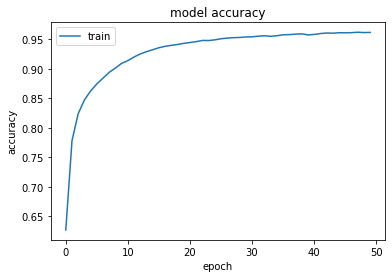

In [53]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

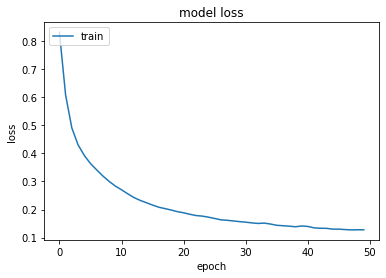

In [54]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# Grafiklendirme

In [57]:
# verisini çektiğimiz herhangi bir satıcı
satici_df = pd.read_csv('Kolaysepet.csv')

In [58]:
satici_df

,Comment,Datetime
0,İndirimden denk getirip çeyizime aldım. 2 defa...,2022-11-05
1,çok güzel bir ürün iyide paketlenmiş,2022-11-05
2,Çeyizim için aldım çok ama çok güzel bi ürün k...,2022-21-04
3,Çok güzel ürün,2022-08-05
4,Tezgahtaki yerini aldı kargolama gayet Hızlı v...,2022-09-05
...,...,...
417,Defosuz geldiği için çok mutluyum satıcıya teş...,2022-22-03
418,"Ürünün garanti belgesi çıkmadı, satıcıyla bu k...",2022-22-02
419,Harika bir olay,2022-22-02
420,dun elime ulaştı. urun bozuk çıktı. iade ettim,2022-22-02


In [59]:
#Etiketler
Datetimes = np.array(satici_df['Datetime'])

#Yorumlar
Comments = np.array(satici_df['Comment'])

In [60]:
satici_tokens = tokenizer.texts_to_sequences(Comments)

In [61]:
tokens_pad = pad_sequences(satici_tokens, maxlen=max_tokens)
tokens_pad.shape

(422, 32)

In [62]:
model.predict(tokens_pad)

array([[0.01035651, 0.12866725, 0.8384513 ],
       [0.01074287, 0.27404818, 0.6221222 ],
       [0.00435171, 0.13486342, 0.92473114],
       ...,
       [0.01410833, 0.04462747, 0.94076115],
       [0.9028672 , 0.04047883, 0.01747769],
       [0.00526671, 0.11372133, 0.93037695]], dtype=float32)

In [63]:
#Alınan yorumların değerleri => Pozitif / negatif / nötr
degerler = []
for i in range(0, len(tokens_pad)):
    x = np.argmax(model.predict(tokens_pad)[i])
    degerler.append(x - 1)

degerler

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 -1,
 1,
 1,
 0,
 -1,
 0,
 0,
 -1,
 0,
 1,
 1,
 0,
 -1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 -1,
 -1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 -1,
 0,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,


In [64]:
len(Datetimes)

422

In [65]:
len(degerler)

422

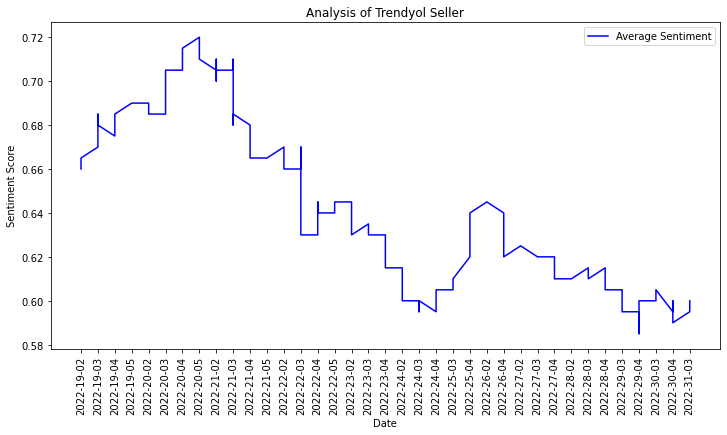

In [66]:
import matplotlib.pyplot as plt

%matplotlib inline

satici_df['value'] = degerler

dates = np.array(satici_df['Datetime'])
indices = np.argsort(dates)
window = 200
dates = dates[indices][window:]
values = np.array(satici_df['value'])[indices]
windows = pd.Series(values).rolling(window)
moving_averages = windows.mean()[window:]


plt.figure(figsize=(12,6))
plt.plot(dates, moving_averages, color='blue', label='Average Sentiment')

plt.title('Analysis of Trendyol Seller')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=90)
plt.legend();
plt.savefig('grafigim.png')